# Exploratory Linear Quadratic Algorithm

In [ ]:
"""
Implementation of Exploratory Linear Quadratic Algorithm
Primary Sources:
Wang, H., Zariphopoulou, T., & Zhou, X. Y. (2019). Exploration versus exploitation in reinforcement learning: a stochastic control approach. Available at SSRN 3316387.
Wang, H, & Zhou, XY. Continuous‐time mean–variance portfolio selection: A reinforcement learning framework. Mathematical Finance. (2020); 30: 1273– 1308. https://doi.org/10.1111/mafi.12281

Author: David Hyland
"""

In [3]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.optimize import minimize
from sympy import symbols, Eq, solve, lambdify
from math import sqrt,exp,e,pi,log

## Environment

In [4]:
class LQ_Environment:
    '''
    reward_params: 5 element dictionary, 
    drift and volatility: 2 element arrays containing A,B,C,D
    '''
    def __init__(self,reward_params,drift,volatility,rho,dt,n,M,explore=2,decay=False,naive=False):        
        # Environment parameters
        self.dt = dt
        self.n = n # Number of timesteps per trajectory
        self.M = M # Number of iterations
        self.reward_params = reward_params
        self.drift = drift
        self.volatility = volatility
        self.rho = rho
        self.delta = 0
        self.gamma = 0
        self.stationary = True
        self.decay = decay # Whether to exponentially decay the exploration rate over time
        self.naive = naive # Whether to perform naive estimating procedure or ELQ
        self.real_t = 0
        
        # Make trajectories predictable
        np.random.seed(1)
        
        # EMV parameters
        self.eta_t = 0.00005
        self.eta_p = 0.0005
        self.x0 = 1
        self.explore = explore
#         self.theta = [0,-3/64,-0.5]
        self.theta = [0.2,0.05,-0.05]
        self.phi = 0

        # Create agent and initialise policy
        self.elq_agent = ELQ_Agent(self.eta_t,self.eta_p,self.x0,self.explore,\
                                   self.theta,self.phi,rho,0,self.dt,self.reward_params,decay=self.decay,naive=self.naive)
        
        # Initialise values of k1 and k2 for use in optimal value calculations
        self.k2 = self.elq_agent.calc_k2(self.drift[0],self.drift[1],self.volatility[0],self.volatility[1])
        self.k1 = self.elq_agent.calc_k1(self.drift[0],self.drift[1],self.volatility[0],self.volatility[1])
        print(self.k1,self.k2)
        
        # Store data for plotting
        self.trajectories = []
        self.phi_history = [self.elq_agent.phi]
        self.theta_history = [self.elq_agent.theta]
        self.policy_history = []
        self.state_history = []
        self.reward_history = [0]
    
    # Run the EMV algorithm over the specified number of episodes
    # optimal: whether or not the agent acts optimally or not
    # new update: whether to use the original or new update scheme for the lagrange multiplier
    def ELQ(self,optimal=False):
        # Main loop
        for k in range(self.M):
            state_trajectory = self.generate_state_trajectory(optimal)
            
            # Store data and update parameters
            if(not optimal):
                self.elq_agent.update_parameters(state_trajectory)
                self.phi_history.append(self.elq_agent.phi)
                self.theta_history.append([self.elq_agent.theta[0],self.elq_agent.theta[1],self.elq_agent.theta[2]])

            self.trajectories.append(state_trajectory)
        return self.trajectories
    
    # Generate a single wealth trajectory according to the agent's current policy
    def generate_state_trajectory(self,optimal):
        # Initialise sample wealth trajectory
        state_trajectory = [(0,self.elq_agent.x)]
        
#         print(self.elq_agent.check_constraints(self.drift[0],self.drift[1]))
        
        if(optimal):
            A,B,C,D = self.drift[0],self.drift[1],self.volatility[0],self.volatility[1]
            mean,var = self.elq_agent.get_optimal_params(A,B,C,D,self.k2,self.k1)
        else:
            mean,var = self.elq_agent.get_policy_params()
            
        self.policy_history.append([mean,var])
        
        # Reward parameters for calculating rewards
        M = self.reward_params['M']
        R = self.reward_params['R']
        N = self.reward_params['N']
        P = self.reward_params['P']
        Q = self.reward_params['Q']
        
        # Generate wealth trajectory
        for i in range(self.n):
            self.real_t += 1
            t = i*self.dt

            # Sample allocation u from the current policy
            if(optimal):
                allocation = self.elq_agent.optimal_policy(A,B,C,D,self.k2,self.k1,i,self.n)
            else:
                allocation = self.elq_agent.sample_policy(i,self.n)
            
            # Increment the wealth process
            state_inc = self.state_increment(allocation)
            self.elq_agent.x += state_inc
            state_trajectory.append((t,self.elq_agent.x))
            
            # Calculate discounted reward
            x = self.elq_agent.x
#             print(allocation,self.real_t, (exp(-self.rho*self.real_t*self.dt)*((M/2)*(x**2)\
#                                     + R*x*allocation + (N/2)*(allocation**2) + P*x + Q*allocation)*self.dt))
            self.reward_history.append(self.reward_history[-1] - (exp(-self.rho*self.real_t*self.dt)*((M/2)*(x**2)\
                                    + R*x*allocation + (N/2)*(allocation**2) + P*x + Q*allocation)*self.dt))
        
        self.elq_agent.unknown_params = [0,0]
        
        return state_trajectory

    # Price increment in the stationary/nonstationary scenario
    def state_increment(self,allocation):
        if(self.stationary):
            # Increment of brownian motion
            dW = np.random.normal(0,1) * sqrt(self.dt)
            state_increment = (self.drift[0]*self.elq_agent.x + self.drift[1]*allocation)*self.dt + \
                            (self.volatility[0]*self.elq_agent.x + self.volatility[1]*allocation)*dW
        else:
            # Calculate price increment
            dW0 = np.random.normal(0,1) * sqrt(self.dt)
            state_increment = (self.drift[0]*self.elq_agent.x + self.drift[1]*allocation)*self.dt + \
                            (self.volatility[0]*self.elq_agent.x + self.volatility[1]*allocation)*dW0
        
        return state_increment

## ELQ Agent

In [5]:
class ELQ_Agent:
    def __init__(self,eta_t,eta_p,x0,explore,theta,phi,rho,leverage,dt,reward_params,decay=False,naive=False):
        self.eta_t = eta_t # Learning rate for theta vector
        self.eta_p = eta_p # Learning rate for phi
        self.x0 = x0 # Remember the initial state
        self.x = x0 # Current state
        self.explore = explore # Exploration rate/temperature parameter lambda
        self.theta = theta # Vector of theta parameters
        self.phi = phi # Single phi parameter
        self.policy_mean = 0.1 # Mean of the current Gaussian policy
        self.policy_var = 1 # Variance of the current Gaussian policy
        self.rho = rho # Discount factor
        self.leverage = leverage # Constraint on control
        self.dt = dt # Increment size
        self.reward_params = reward_params # Dictionary containing values for reward function
        self.volatility_params = [0,0] # Store estimates for the volatility parameters C and D
        self.unknown_params = [0,0] # Stores results of calculated parameters
        self.decay = decay # Whether or not to decay exploration
        self.naive = naive # Whether to perform naive estimation or ELQ
    
    # Pass in a list of parameter values to extract and a list will be returned with their values
    def get_params(self,param_names):
        values = []
        try:
            for i in param_names:
                values.append(self.reward_params[i.upper()])
        except KeyError:
            print("One of the parameters you requested does not exist.")
            return None
        return values
    
    # Sample allocation from the optimal policy
    def optimal_policy(self,A,B,C,D,k2,k1,k,n):
        opt_mean,opt_var = self.get_optimal_params(A,B,C,D,k2,k1)
        # Optimal exploratory control
        if(opt_var > 0):
            if(self.decay):
                opt_var *= exp(-k/n)
            allocation = np.random.normal(opt_mean,sqrt(opt_var))
        # Optimal classical control
        else:
            allocation = opt_mean
        return allocation
    
    def get_optimal_params(self,A,B,C,D,k2,k1):
        x = self.x
        R,N,Q = self.get_params(['R','N','Q'])
        opt_mean = ((k2*(B+C*D)-R)*x + k1*B - Q)/(N-k2*(D**2))
        # Perform Exploration
        if(self.explore != 0):
            opt_var = self.explore/(N-k2*(D**2))
        else:
            opt_var = 0
        return opt_mean,opt_var
    
    def check_constraints(self,A,B):
        C,D = self.volatility_params
        M,N,P,Q,R = self.get_params(['M','N','P','Q','R'])
        k2 = 2*self.theta[2]#self.calc_k2(A,B,C,D)
        k1 = self.theta[1]
        
        print( not(k2*(D**2) - N == 0), (-(k1**2)*k2*(D**2)*M - (k1**2)*k2*(C**2)*N + (k1**2)*M*N +\
        2*k1*(k2**2)*(D**2)*P - 2*k1*k2*N*P - 2*k1*(k2**2)*C*D*Q - (k2**2)*(Q**2) + 2*(k1**2)*k2*C*D*R + 
       2*k1*k2*Q*R - (k1**2)*(R**2) + (k1**2)*(k2**2)*(D**2)*self.rho - (k1**2)*k2*N*self.rho <= 0))
        
        print(M >= 0,N > 0,((N-(D**2)*k2) > 0 ),(k2 < 0),\
               (self.rho > 2*A+(C**2) + max(((D*R)**2 -2*N*R*(B+C*D))/N,0)),(R**2 < M*N))
        return (M >= 0 and N > 0 and ((N-(D**2)*k2) > 0 ) and (k2 < 0) and\
               (self.rho > 2*A+(C**2) + max(((D*R)**2 -2*N*R*(B+C*D))/N,0)) and (R**2 < M*N))

    # Calculate parameterised value function
    def value_function(self,x):
        return self.theta[2]*(x**2) + self.theta[1]*x + self.theta[0]
                                         
    # Update the parameter values based on sampled market data
    # samples: list of tuples containing (t_i,x_i)
    def update_parameters(self,samples):
        if(self.naive):
            A,B = self.estimate_drift()
            C,D = self.estimate_volatility()
            self.unknown_params = [A,B]
            self.volatility_params = [C,D]
        else:
            # Use arrays to store the increments (theta_1, theta_2, phi_1, phi_2)
            dtheta = [0.0,0.0]
            dphi = 0.0

            # Simulate estimation of the parameters C and D
            C,D =  self.estimate_volatility()
            self.volatility_params = [C,D]

            for i in range(len(samples) - 1):
                # Extract the relevant data from the samples array
                t_i = samples[i][0]
                t_i1 = samples[i+1][0]
                x_i = samples[i][1]
                x_i1 = samples[i+1][1]                      

                # Calculate quantities used in determining the gradient
                vdot = (self.value_function(x_i1) - self.value_function(x_i))/self.dt
                entropy = self.phi
                td_error = vdot - self.explore*entropy
                if(td_error > 20):
                    td_error = 1
    #                 print("OUCH +")
                elif(td_error < -20):
                    td_error = -1
    #                 print("OUCH -")
                error_dt = td_error*self.dt

                # Add to the cumulative sum of errors
                dtheta[0] += td_error*(x_i1-x_i)
                dtheta[1] += td_error*(x_i1**2 - x_i**2)
                dphi += error_dt

            # Multiply by the relevant scalars
            dphi = -self.explore * dphi

    #         print(dtheta)

            # Update the parameters
            self.theta[1] -= self.eta_t*dtheta[0]
            self.theta[2] -= self.eta_t*dtheta[1]
            self.theta[0] = self.calc_theta0(C,D)
            self.phi -= self.eta_p*dphi
    #         print(self.theta,self.phi)
    
    # Sample allocation from the current policy
    def sample_policy(self,k,n):
        mean, var = self.get_policy_params()
        if (var > 0):
            if(self.decay):
                var *= exp(-k/n)
            allocation = np.random.normal(mean,sqrt(var))
        else:
            allocation = mean
        # Apply leverage constraint if non-zero value provided
        if (self.leverage > 0 and abs(allocation) > self.leverage*abs(self.x)):
            return np.sign(allocation) * self.x
        return allocation
    
    # Get the current mean and variance of the policy based on the current state
    def get_policy_params(self):
        # Extract data needed for calculations
        k2 = 2*self.theta[2]
        k1 = self.theta[1]
        # Estimate if parameters are not initialized
        if(self.volatility_params == [0,0]):
            C,D = self.estimate_volatility()
            self.volatility_params = [C,D]
        else:
            C,D = self.volatility_params
        N,Q,R = self.get_params(['N','Q','R'])
        if(self.unknown_params == [0,0] and not self.naive):
            A,B = self.solve_AB()
            self.unknown_params = [A,B]
        else:
            A,B = self.unknown_params
        
        # Compute mean and variance of parameterised policy
        mean = ((k2*(B+C*D) - R)*self.x + k1*B - Q)/(N - k2*(D**2))
        var = self.explore/(N - k2*(D**2))
        return mean, var
    
    def equation_1(self,a,*args):
        b,k2,k1,c,d,m,r,n,p,q,rho = args
        return -((k2*(b+c*d) - r)**2/(n - k2*(d**2)) + k2 * (2*a+(c**2)) - m - rho*k2)
    
    def equation_2(self,b,*args):
        a,k2,k1,c,d,m,r,n,p,q,rho = args
        return ((k1*b - q)*(k2*(b+c*d) - r))/(n-k2*d**2) + k1*a - p - rho* k1
    
    def solve_AB(self):
        # Extract values from dictionary
        c,d = self.volatility_params
        m,r,n,p,q = self.get_params(['M','R','N','P','Q'])
        rho = self.rho
        k2 = 2*self.theta[2]
        k1 = self.theta[1]
        
#         print(self.theta[2],self.theta[1])
        # Create variables
        a,b = symbols('a b',real=True)

        # Plugging into algebraic equations
        eq1 = (k2*(b+c*d) - r)**2/(n - k2*(d**2)) + k2 * (2*a+(c**2)) - m - rho*k2
        eq2 = ((k1*b - q)*(k2*(b+c*d) - r))/(n-k2*d**2) + k1*a - p - rho* k1
        
        # Solve for A and B
        sol_dict = solve((eq1,eq2),(a,b),quick=True)
        
#         A,B = sol_dict[0]
        
        if len(sol_dict) > 0:
            # Select smaller of the roots
            sol1 = sol_dict[0]
            sol2 = sol_dict[1]
            ordered_sols = [sol1,sol2]
#             if abs(sol1[0] - self.unknown_params[0]) > abs(sol2[0] - self.unknown_params[0]):
#                 ordered_sols = [sol2,sol1]
#             else:
#                 ordered_sols = [sol1,sol2]
            # Selecting the root which gives the proper value of k2
            for i in range(len(ordered_sols)):
                A,B = ordered_sols[i]
                k2 = symbols('k2',real=True)
                eq3 = (k2*(B+c*d) - r)**2/(n - k2*(d**2)) + k2 * (2*A+(c**2)) - m - rho*k2
                root_check = solve(eq3,k2,quick=True)
                if len(root_check) > 0 and (root_check[0] < 0 or root_check[1] < 0):
    #                 print(root_check)
                    break
        else:
#             sol_dict_2 = solve(eq1,a,quick=True)
#             A = sol_dict_2[0]
#             print(sol_dict_2)
#             eq3 = -(((k1*b - q)*(k2*(b+c*d) - r))/(n-k2*d**2) + k1*A - p - rho* k1)
#             equation_3 = lambdify(b,eq3)
#             maximizer = minimize(equation_3,[0])
#             print(maximizer.x[0])
#             B = maximizer.x[0]
            A,B = self.unknown_params

#         print(sol_dict,A,B)
        return A,B
        
    def calc_theta0(self,C,D):
        k2 = 2*self.theta[2]
        k1 = self.theta[1]
        C,D = self.volatility_params
        N,Q = self.get_params(['N','Q'])
        A,B = self.solve_AB()
        rho = self.rho
        
        # Plug values into formula
#         print(k1,k2,A,B,C,D,N,Q,rho)
        theta0 = (k1*B-Q)**2/(2*rho*(N-k2*(D**2))) + \
                 ((self.explore)/(2*rho))*(log((2*pi*e*self.explore)/(N-k2*(D**2)))-1)
        return theta0
    
    # Calculates theoretical value of k2, k1 for given parameter values
    def calc_k2(self,a,b,c,d):
        m,r,n,p,q = self.get_params(['M','R','N','P','Q'])
        e = self.rho - (2*a+(c**2))
        f = b + c*d
        g = e*n+2*f*r-m*(d**2)
        k2 = ((g-sqrt(g**2 - 4*(f**2+e*(d**2))*(r**2-m*n)))/(f**2+e*(d**2)))/2
        return k2
    
    def calc_k1(self,a,b,c,d):
        m,r,n,p,q = self.get_params(['M','R','N','P','Q'])
        k2 = self.calc_k2(a,b,c,d)
        f = b + c*d
        k1 = (p*(n-k2*(d**2)) - q*r)/(k2*b*f + (a-self.rho)*(n-k2*(d**2)) - b*r)
        return k1
    
    # Simulate asymptotically normal estimators for the parameters C and D
    def estimate_volatility(self):
        C = np.random.normal(-1,1)
        D = np.random.normal(-1,1)
        return C,D
    
    # Simulate asymptotically normal estimators for the parameters A and B
    def estimate_drift(self):
        A = np.random.normal(1,10)
        B = np.random.normal(4,10)
        return A,B
        

## ELQ User Functions

In [6]:
# Calculate difference in asymptotic rewards between two runs
def calc_reward_diff(rewards1,rewards2,n):
    if len(rewards1) < n  or len(rewards2) < n:
        print("Insufficient data")
    else:
        ave_1 = np.mean(rewards1[-n:])
        ave_2 = np.mean(rewards2[-n:])
        diff = ave_1 - ave_2
#         print("Difference: ",diff)
    return diff

def exploration_cost(explore,rho):
#     print("Exploration cost:", explore/(2*rho))
    return explore/(2*rho)

## ELQ Simulation Results

In [7]:
# Main program
reward_params = {'M':2,'R':-1,'N':1,'P':-1,'Q':-1}
drift = [1,4]
volatility = [-1,-1]
rho = 32
dt,n,M = 1/30000,10,600
# Standard ELQ
elq_env = LQ_Environment(reward_params,drift,volatility,rho,dt,n,M)
elq_wealths = elq_env.ELQ(False)
# ELQ With decaying exploration
elq_env_d = LQ_Environment(reward_params,drift,volatility,rho,dt,n,M,decay=True)
elq_wealths_d = elq_env_d.ELQ(False)
# Optimal Classical LQR
opt_lq_env = LQ_Environment(reward_params,drift,volatility,rho,dt,n,M,explore = 0)
opt_lq_wealths = opt_lq_env.ELQ(True)
# Optimal Exploratory LQR
opt_elq_env = LQ_Environment(reward_params,drift,volatility,rho,dt,n,M,explore = 2)
opt_elq_wealths = opt_elq_env.ELQ(True)
# Optimal Exploratory LQR with decaying exploration
opt_elq_env_d = LQ_Environment(reward_params,drift,volatility,rho,dt,n,M,decay=True)
opt_elq_wealths_d = opt_elq_env_d.ELQ(True)

0.06931658509028461 -0.05066856531707621
0.06931658509028461 -0.05066856531707621
0.06931658509028461 -0.05066856531707621
0.06931658509028461 -0.05066856531707621
0.06931658509028461 -0.05066856531707621


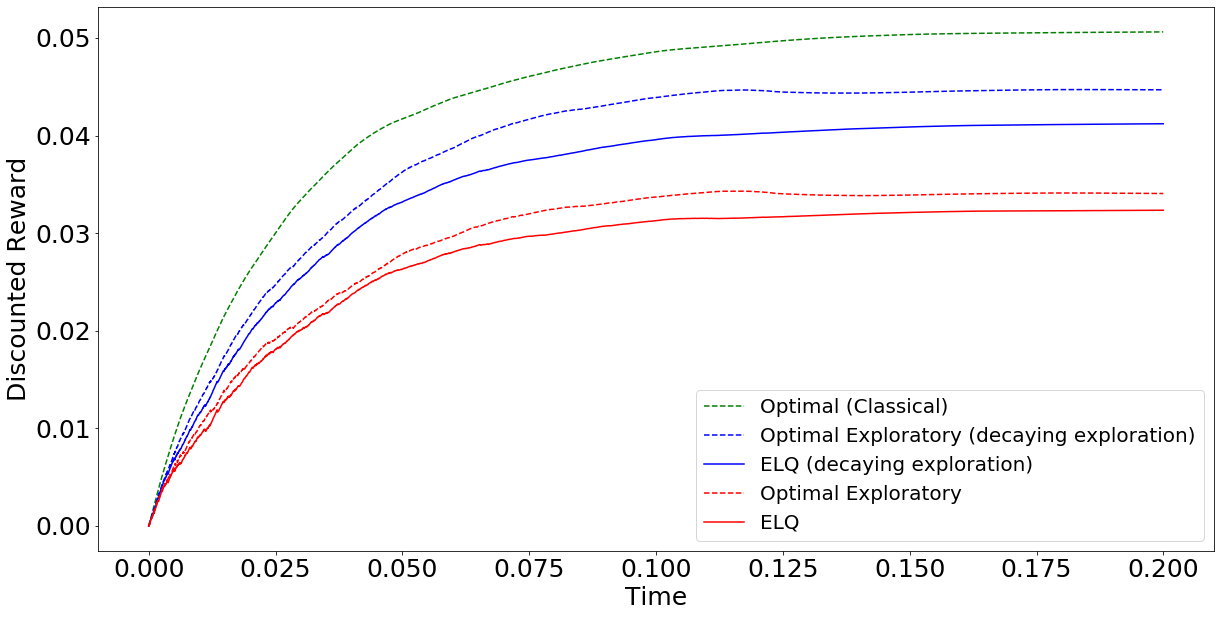

In [11]:
# Plotting mean
reward_history = elq_env.reward_history
decay_reward_history = elq_env_d.reward_history
opt_reward_history = opt_lq_env.reward_history
opt_elq_reward_hist = opt_elq_env.reward_history
opt_decay_reward_hist = opt_elq_env_d.reward_history
xaxis = [i*dt for i in range(M*n)]
plt.figure(figsize=(20,10))
plt.plot(xaxis,[np.mean(opt_reward_history[i-1:i]) for i in range(1,len(opt_reward_history),1)],color="green",linestyle="--",label="Optimal (Classical)")
plt.plot(xaxis,[np.mean(opt_decay_reward_hist[i-1:i]) for i in range(1,len(opt_decay_reward_hist),1)],color="blue",linestyle="--",label="Optimal Exploratory (decaying exploration)")
plt.plot(xaxis,[np.mean(decay_reward_history[i-1:i]) for i in range(1,len(decay_reward_history),1)],color="blue",label="ELQ (decaying exploration)")
plt.plot(xaxis,[np.mean(opt_elq_reward_hist[i-1:i]) for i in range(1,len(opt_elq_reward_hist),1)],color="red",linestyle="--",label="Optimal Exploratory")
plt.plot(xaxis,[np.mean(reward_history[i-1:i]) for i in range(1,len(reward_history),1)],color="red",label="ELQ")
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.ylabel('Discounted Reward',fontsize=25)
plt.xlabel('Time',fontsize=25)
plt.legend()
plt.show()

In [12]:
opt_diff = calc_reward_diff(opt_reward_history,opt_elq_reward_hist,100)
cost = exploration_cost(2,32)
actual_e_opt_diff = calc_reward_diff(opt_elq_reward_hist,reward_history,100)
actual_decay_e_opt_diff = calc_reward_diff(opt_elq_reward_hist,decay_reward_history,100)
decay_nondecay_diff = calc_reward_diff(decay_reward_history,reward_history,100)
print("Difference between optimal classical and exploratory rewards: ",opt_diff)
print("Exploration cost: ",cost)
print("Difference between optimal exploratory and ELQ rewards: ",actual_e_opt_diff)
print("Difference between decaying and non-decaying exploration ELQ rewards: ",decay_nondecay_diff)

Difference between optimal classical and exploratory rewards:  0.016544568079776327
Exploration cost:  0.03125
Difference between optimal exploratory and ELQ rewards:  0.0017222733303868948
Difference between decaying and non-decaying exploration ELQ rewards:  0.008856730354963087


In [ ]:
# Estimation method
naive_elq_env = LQ_Environment(reward_params,drift,volatility,rho,dt,n,M,explore = 0,naive = True)
naive_elq_wealths = naive_elq_env.ELQ(False)
naive_reward_history = naive_elq_env.reward_history
naive_expl_reward_hist = naive_expl_env.reward_history
plt.figure(figsize=(20,10))
plt.plot([np.mean(naive_reward_history[i-1:i]) for i in range(1,len(naive_reward_history),1)],color="purple",label="Estimation LQ")
plt.plot([np.mean(naive_expl_reward_hist[i-1:i]) for i in range(1,len(naive_expl_reward_hist),1)],color="orange",label="Estimation exploratory LQ")
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.ylabel('Discounted Reward',fontsize=25)
plt.xlabel('Timesteps',fontsize=25)
plt.legend()
plt.show()

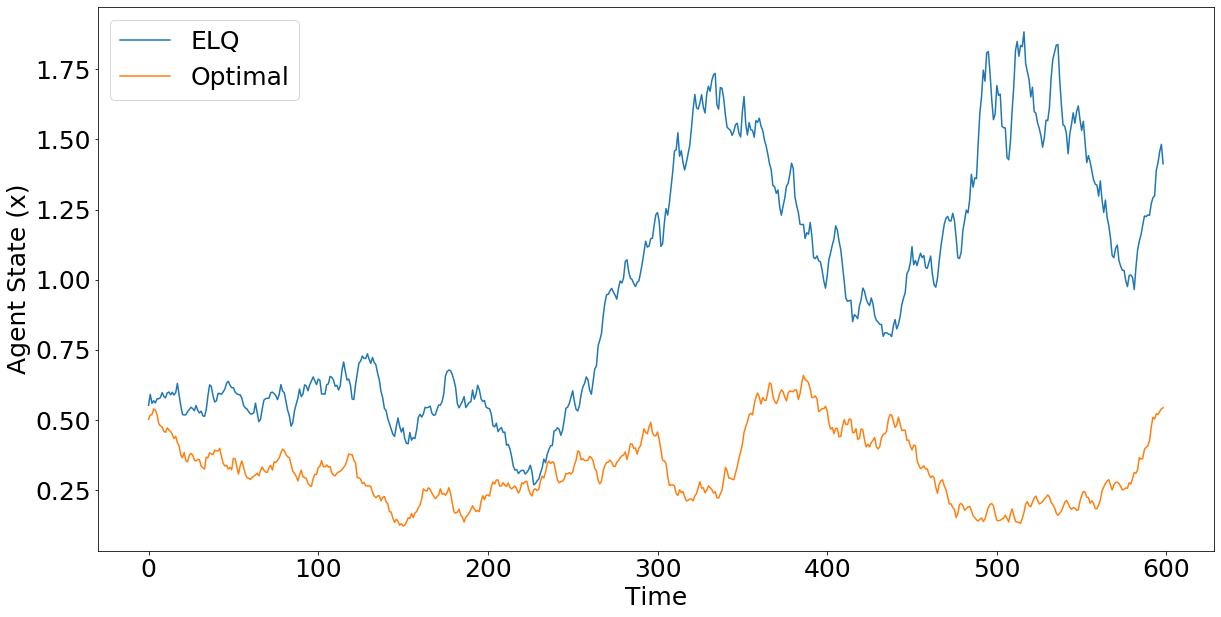

In [14]:
# Agent's state through all training episodes
plt.figure(figsize=(20,10))
plt.plot([np.mean(elq_wealths[i-1:i]) for i in range(1,len(elq_wealths),1)],label="ELQ")
plt.plot([np.mean(opt_lq_wealths[i-1:i]) for i in range(1,len(opt_lq_wealths),1)],label="Optimal")
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.ylabel('Agent State (x)',fontsize=25)
plt.xlabel('Time',fontsize=25)
plt.legend()
plt.show()

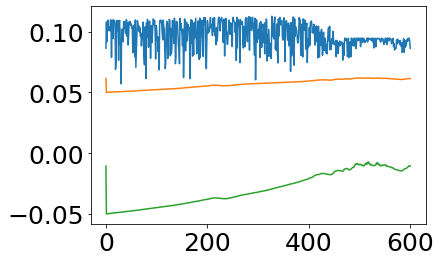

In [15]:
# History of theta parameter
plt.plot(elq_env.theta_history)
plt.show()

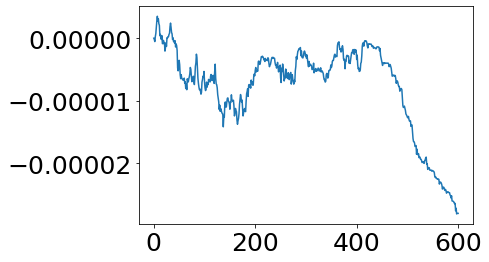

In [16]:
# History of phi parameter
plt.plot(elq_env.phi_history)
plt.show()